Assignment 3 #Author: Syed Kumayl Raza Moosavi - 364013

In the segmentation images, the pixel value should denote the class ID of the corresponding pixel. This is a common format used by most of the datasets

The dataset is a subset of Cityspace Dataset and is already divided into train and test splits. For validation, you can further split the Train part such that 80% is used for training and 20% for validation

Following classes are there in the dataset.  
"Sky",  "Building",  "Pole","Road","Pavement","Tree","SignSymbol",  "Fence",  "Car", "Pedestrian",  "Bicyclist" 

You can use CNN architecture of your own choice, i.e., build VGG, or ResNet style architecture using primitive layers or call in the pre‐implemented architectures available in Keras / Pytorch, whatever framework you are using. 

You can choose any one of  the  following  two options  to complete  this assignment. Please indicate clearly in the REPORT as well as in the beginning of your code submission that which option you have chosen. 

Use two CNN architectures for semantic segmentation. 
1. The first Architecture would be any baseline network, like FCN, U‐NET or SegNet. In this baseline network, VGG Net can be used as backbone. 
2. Enhance the used baseline as the 2nd Architecture. You can experiment with different CNN backbone. e.g if you are using SegNet for semantic segmentation in the first part, then instead of VGG, you may use mobile‐net backbone, or resnet back‐bone or xception backbone or any other. The baseline can also be enhanced by incorporating some enhancements in the architecture. The enhancements can be incorporating global context, as proposed by ParseNet or using ASPP for enhanced segmentation or a unique upsampling module etc. 

Compare  the  results  of  both  the  architectures,  it  is  expected  that  the  qualitative  and quantitative results from 2nd architecture would be better that first

The Python Notebook should also demonstrate the 
1. Neatly written, documented and modular code
2. Use of Data augmentation. 
3. Quantitative  performance  measures  (F1  Score,  Dice,  Accuracy, Sensitivity and Specificity) 
4. Qualitative results i.e. a few of the correctly and incorrectly classified images.  
5. For each of the qualitative image, following should be displayed in the notebook as well as in the report. 
    1. Original Image,
    2. Ground Truth in the form of segmentation mask 
    3. Ground Truth image Super‐imposed on original image
    4. Predicted Image in the form of segmentation mask
    5. Predicted Image Super‐imposed on original image

###  ADD All required libraries

In [1]:
import glob
from skimage import io, util
from scipy import io as sio
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from skimage import data, io
from matplotlib import pyplot as plt

from keras import backend as K
import tensorflow as tf


import os
import random

import tensorflow as tf
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add

from keras.layers import Input


import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape, Add, Concatenate, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.keras.activations import relu

from tensorflow.keras import backend as K

import time

#!pip install segmentation-models

# Function used to reconstruct images patches back to original image

In [2]:
def recon_im(patches: np.ndarray, im_h: int, im_w: int, n_channels: int, stride: int):
    """Reconstruct the image from all patches.
        Patches are assumed to be square and overlapping depending on the stride. The image is constructed
         by filling in the patches from left to right, top to bottom, averaging the overlapping parts.
    Parameters
    -----------
    patches: 4D ndarray with shape (patch_number,patch_height,patch_width,channels)
        Array containing extracted patches. If the patches contain colour information,
        channels are indexed along the last dimension: RGB patches would
        have `n_channels=3`.
    im_h: int
        original height of image to be reconstructed
    im_w: int
        original width of image to be reconstructed
    n_channels: int
        number of channels the image has. For  RGB image, n_channels = 3
    stride: int
           desired patch stride
    Returns
    -----------
    reconstructedim: ndarray with shape (height, width, channels)
                      or ndarray with shape (height, width) if output image only has one channel
                    Reconstructed image from the given patches
    """

    patch_size = patches.shape[1]  # patches assumed to be square

    # Assign output image shape based on patch sizes
    rows = ((im_h - patch_size) // stride) * stride + patch_size
    cols = ((im_w - patch_size) // stride) * stride + patch_size

    if n_channels == 1:
        reconim = np.zeros((rows, cols))
        divim = np.zeros((rows, cols))
    else:
        reconim = np.zeros((rows, cols, n_channels))
        divim = np.zeros((rows, cols, n_channels))

    p_c = (cols - patch_size + stride) / stride  # number of patches needed to fill out a row

    totpatches = patches.shape[0]
    initr, initc = 0, 0

    # extract each patch and place in the zero matrix and sum it with existing pixel values

    reconim[initr:patch_size, initc:patch_size] = patches[0]# fill out top left corner using first patch
    divim[initr:patch_size, initc:patch_size] = np.ones(patches[0].shape)

    patch_num = 1

    while patch_num <= totpatches - 1:
        initc = initc + stride
        reconim[initr:initr + patch_size, initc:patch_size + initc] += patches[patch_num]
        divim[initr:initr + patch_size, initc:patch_size + initc] += np.ones(patches[patch_num].shape)

        if np.remainder(patch_num + 1, p_c) == 0 and patch_num < totpatches - 1:
            initr = initr + stride
            initc = 0
            reconim[initr:initr + patch_size, initc:patch_size] += patches[patch_num + 1]
            divim[initr:initr + patch_size, initc:patch_size] += np.ones(patches[patch_num].shape)
            patch_num += 1
        patch_num += 1
    # Average out pixel values
    reconstructedim = reconim / divim

    return reconstructedim

# Function for losses

In [3]:
def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
  denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

  return 1 - numerator / denominator

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [4]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Import training data and creating patches of training images

In [5]:
#Import training data
train_dir = glob.glob("A3_Dataset/dataset1/images_prepped_train/*")
train_dir_annotations = glob.glob("A3_Dataset/dataset1/annotations_prepped_train/*")

#Resize images to a standard form
from skimage.transform import resize
a=0
train_images, train_masks = [],[]
for item in train_dir:
    image = io.imread(item)/255
    resized_image = resize(image, (500, 500),preserve_range=True)
    train_images.append(resized_image)
    #print(a)
    a=a+1
b=0
for item in train_dir_annotations:
    image = io.imread(item)   
    resized_image = resize(image, (500, 500),preserve_range=True)
    train_masks.append(resized_image)
    #print(b)
    b=b+1
    
train_masks = np.expand_dims(train_masks, axis=3)


#Create 16 patches of each image
train_images2, train_masks2 = [],[]
q=0
for item in train_dir_annotations:
    patches = util.view_as_windows(np.concatenate((train_images[q],train_masks[q]),axis=2),(128,128,4),(120,120,4)).reshape(-1,128,128,4)

    for patch in patches:
        train_images2.append(patch[:,:,:3])
        train_masks2.append(patch[:,:,3])
    q = q + 1
    
#Final train images and masks    
train_images2 = np.array(train_images2)
train_masks2 = np.array(train_masks2).astype(int)
train_masks2 = tf.keras.utils.to_categorical(train_masks2, num_classes=12)

print(train_images2.shape,train_masks2.shape)

(5872, 128, 128, 3) (5872, 128, 128, 12)


# Data Augmentation and validation split (20%) using ImageDataGenerator

In [6]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

datagen.fit(train_images2)

# Function for losses

In [7]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Create keras model for Segmentation Models
# Backbone is Resnet34 with U-Net Architecture

In [8]:
import segmentation_models as sm
from tensorflow import keras
from tensorflow_addons.metrics import F1Score as F1_Score
from tensorflow.keras.callbacks import ModelCheckpoint

keras.backend.set_image_data_format('channels_last')

BACKBONE = 'resnet34'


# define model
model = sm.Unet(BACKBONE, input_shape=(None, None, 3), classes=12, activation='softmax', encoder_weights=None,  decoder_use_batchnorm=False)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),
                   loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",
                                                                            dice_coef,
                                                                            get_f1,
                                                                           specificity,
                                                                           sensitivity])

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


#Learning rate reduction on Plateau and model saving
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1), model_checkpoint_callback
    ]




Segmentation Models: using `keras` framework.


# Model training and Time calculated for model.fit on:
# training data (80%), validation data (20%)

In [9]:
t0 = time.time()

results = model.fit(datagen.flow(train_images2, train_masks2, batch_size=16, subset='training'),
                    verbose=1, epochs=20, callbacks = callbacks,
                    validation_data=datagen.flow(train_images2, train_masks2, batch_size=16, subset='validation'))


print("Training Time = " , time.time()-t0, "secs")

Epoch 1/20
294/294 [==============================] - 670s 2s/step - loss: 1.3679 - accuracy: 0.5646 - dice_coef: 0.4333 - get_f1: 0.5025 - specificity: 0.9921 - sensitivity: 0.3734 - val_loss: 9.3573 - val_accuracy: 0.5071 - val_dice_coef: 0.4711 - val_get_f1: 0.4709 - val_specificity: 0.9673 - val_sensitivity: 0.4193 - lr: 0.0010
Epoch 2/20
294/294 [==============================] - 659s 2s/step - loss: 1.1258 - accuracy: 0.6445 - dice_coef: 0.5229 - get_f1: 0.6133 - specificity: 0.9893 - sensitivity: 0.4967 - val_loss: 1.2296 - val_accuracy: 0.6500 - val_dice_coef: 0.5455 - val_get_f1: 0.6212 - val_specificity: 0.9829 - val_sensitivity: 0.5365 - lr: 0.0010
Epoch 3/20
294/294 [==============================] - 669s 2s/step - loss: 1.0348 - accuracy: 0.6799 - dice_coef: 0.5606 - get_f1: 0.6582 - specificity: 0.9888 - sensitivity: 0.5540 - val_loss: 1.0755 - val_accuracy: 0.6516 - val_dice_coef: 0.5552 - val_get_f1: 0.6424 - val_specificity: 0.9851 - val_sensitivity: 0.5525 - lr: 0.001

# Plot Losses, Accuracy and dice-coef

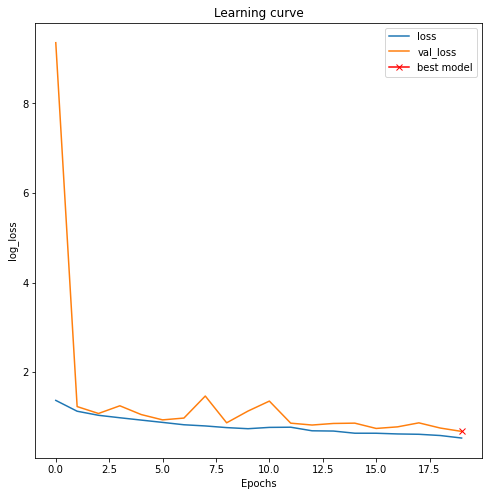

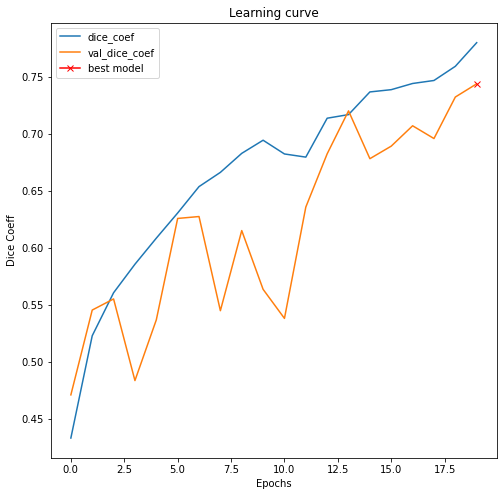

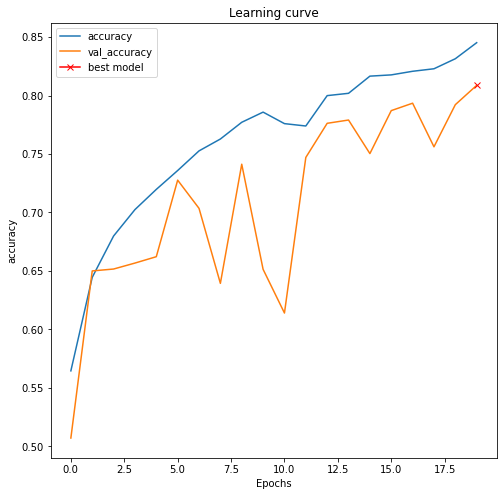

In [11]:
#Plot of log loss
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.show()
#plt.savefig('./Results/plots/train_loss1.png')

#Plot of dice coef
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coeff")
plt.legend();
plt.show()
#plt.savefig('./Results/plots/train_dice1.png')

#Plot of classification accuracy
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();
plt.show()
#plt.savefig('./Results/plots/train_accuracy1.png')

# Import test data and creating patches of test images

In [8]:
#Import test data
test_dir = glob.glob("A3_Dataset/dataset1/images_prepped_test/*")
test_dir_annotations = glob.glob("A3_Dataset/dataset1/annotations_prepped_test/*")

#Resize images to a standard form
a=0
test_images, test_masks = [],[]
for item in test_dir:
    image = io.imread(item)/255
    resized_image = resize(image, (500, 500),preserve_range=True)
    test_images.append(resized_image)
    #print(a)
    a=a+1
b=0
for item in test_dir_annotations:
    image = io.imread(item)   
    resized_image = resize(image, (500, 500),preserve_range=True)
    test_masks.append(resized_image)
    #print(b)
    b=b+1
    
test_masks = np.expand_dims(test_masks, axis=3)

#Create 16 patches of each image
test_images2, test_masks2 = [],[]
q=0
for item in test_dir_annotations:
    patches = util.view_as_windows(np.concatenate((test_images[q],test_masks[q]),axis=2),(128,128,4),(120,120,4)).reshape(-1,128,128,4)

    for patch in patches:
        test_images2.append(patch[:,:,:3])
        test_masks2.append(patch[:,:,3])
    q = q + 1
    
#Final Test Image and Mask    
test_images2 = np.array(test_images2)
test_masks2 = np.array(test_masks2).astype(int)
test_masks2 = tf.keras.utils.to_categorical(test_masks2, num_classes=12)

print(test_images2.shape,test_masks2.shape)

(1616, 128, 128, 3) (1616, 128, 128, 12)


In [9]:
del train_images, train_masks, train_dir, train_dir_annotations, test_images, test_masks, test_dir, test_dir_annotations

# Evaluation of test images and time calculation

In [14]:
t0 = time.time()

results = model.evaluate(
    x=test_images2,
    y=test_masks2,
    batch_size=16,
    verbose=1)

print("Evaluation Time = " , time.time()-t0, "secs")

101/101 [==============================] - 43s 418ms/step - loss: 0.6042 - accuracy: 0.8331 - dice_coef: 0.7455 - get_f1: 0.8376 - specificity: 0.9920 - sensitivity: 0.7843
Evaluation Time =  42.95797777175903 secs


# Prediction of test images and time calculation

In [15]:
t0 = time.time()

results = model.predict(
    x=test_images2,
    batch_size=16
)

print(results.shape)

print("Prediction Time = " , time.time()-t0, "secs")

(1616, 128, 128, 12)
Prediction Time =  37.03239607810974 secs


In [16]:
y_pred = np.argmax(results, axis=-1)
print(y_pred.shape)
y_orig = np.argmax(test_masks2, axis=-1)

(1616, 128, 128)


In [17]:
del model, results

# Second Architecture: DeepLab V3
# Functions are inserted here to configure this architecture

In [10]:
WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation('relu')(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation('relu')(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = tf.keras.layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = tf.keras.layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def relu6(x):
    return relu(x, max_value=6)


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1]  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC or Cityscapes. This model is available for TensorFlow only.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images. None is allowed as shape/width
        classes: number of desired classes. PASCAL VOC has 21 classes, Cityscapes has 19 classes.
            If number of classes not aligned with the weights used, last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone. Pretrained is only available for alpha=1.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation('relu')(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation('relu')(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same',
                   use_bias=False, name='Conv')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Lambda(lambda x: K.expand_dims(x, 1))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation('relu')(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = Lambda(lambda x: tf.compat.v1.image.resize(x, size_before[1:3],
                                                    method='bilinear', align_corners=True))(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation('relu', name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        size_before2 = tf.keras.backend.int_shape(x)
        x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                        size_before2[1:3] * tf.constant(OS // 4),
                                                        method='bilinear', align_corners=True))(x)

        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation('relu')(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = Lambda(lambda xx: tf.compat.v1.image.resize(xx,
                                                    size_before3[1:3],
                                                    method='bilinear', align_corners=True))(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    model = Model(inputs, x, name='deeplabv3plus')

    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    elif weights == 'cityscapes':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_X_CS,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_MOBILE_CS,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    return model

def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return preprocess_input(x, mode='tf')

# Create Keras Model
# Backbone is xception with DeepLab V3 Architecture

In [11]:
model = Deeplabv3(weights=None, input_tensor=None, input_shape=(128, 128, 3), classes=12, backbone='xception',
               OS=16, alpha=1., activation='softmax')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True),
                   loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["accuracy",
                                                                            dice_coef,
                                                                            get_f1,
                                                                           specificity,
                                                                           sensitivity])

checkpoint_filepath = './tmp2/checkpoint'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


#Learning rate reduction on Plateau and model saving
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1), model_checkpoint_callback
    ]

# Model training and Time calculated for model.fit on:
# training data (80%), validation data (20%)

In [ ]:
t0 = time.time()

results = model.fit(datagen.flow(train_images2, train_masks2, batch_size=16, subset='training'),
                    verbose=1, epochs=20, callbacks = callbacks,
                    validation_data=datagen.flow(train_images2, train_masks2, batch_size=16, subset='validation'))


print("Training Time2 = " , time.time()-t0, "secs")

Epoch 1/20
294/294 [==============================] - 1321s 4s/step - loss: 1.0931 - accuracy: 0.6546 - dice_coef: 0.5428 - get_f1: 0.6321 - specificity: 0.9868 - sensitivity: 0.5364 - val_loss: 2.3968 - val_accuracy: 0.3125 - val_dice_coef: 0.2483 - val_get_f1: 0.3160 - val_specificity: 0.9378 - val_sensitivity: 0.3160 - lr: 0.0010
Epoch 2/20
294/294 [==============================] - 1340s 5s/step - loss: 0.8690 - accuracy: 0.7267 - dice_coef: 0.6233 - get_f1: 0.7199 - specificity: 0.9878 - sensitivity: 0.6397 - val_loss: 1.8855 - val_accuracy: 0.4383 - val_dice_coef: 0.4332 - val_get_f1: 0.4441 - val_specificity: 0.9556 - val_sensitivity: 0.4247 - lr: 0.0010
Epoch 3/20
294/294 [==============================] - 1331s 5s/step - loss: 0.8032 - accuracy: 0.7508 - dice_coef: 0.6523 - get_f1: 0.7478 - specificity: 0.9882 - sensitivity: 0.6757 - val_loss: 0.9947 - val_accuracy: 0.6844 - val_dice_coef: 0.5764 - val_get_f1: 0.6773 - val_specificity: 0.9863 - val_sensitivity: 0.5915 - lr: 0.

In [ ]:
del train_images2, train_masks2

# Plot loss, accuracy and dice coef

In [ ]:
#Plot of log loss
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.show()
#plt.savefig('./Results/plots/train_loss2.png')

#Plot of dice coef
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["dice_coef"], label="dice_coef")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coeff")
plt.legend();
plt.show()
#plt.savefig('./Results/plots/train_dice2.png')

#Plot of classification accuracy
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();
plt.show()
#plt.savefig('./Results/plots/train_accuracy2.png')

# Evaluation on Test Images and Time Calculated

In [ ]:
t0 = time.time()

results = model.evaluate(
    x=test_images2,
    y=test_masks2,
    batch_size=16,
    verbose=1)
print("Evaluation Time2 = " , time.time()-t0, "secs")

# Prediction on Test Images and Time Calculated

In [ ]:
t0 = time.time()

results = model.predict(
    x=test_images2,
    batch_size=16
)

print(results.shape)


print("Prediction Time2 = " , time.time()-t0, "secs")

In [ ]:
y_pred2 = np.argmax(results, axis=-1)
print(y_pred2.shape)
y_orig = np.argmax(test_masks2, axis=-1)

# Qualitative Analysis for first model. Output images with ground truth and with predicted Segmentation Masks

In [ ]:
tf.compat.v1.disable_eager_execution()
new_y_pred = y_pred.reshape(101, 16, 128, 128)
new_y_orig = y_orig.reshape(101, 16, 128, 128)
new_test_images2 = test_images2.reshape(101, 16, 128, 128,3)

a=[]
b=[]
c=[]
for q in range(0,16):
    tmp = recon_im(new_y_pred[q],512,512,1,128)
    a.append(tmp)
    tmp = recon_im(new_y_orig[q],512,512,1,128)
    b.append(tmp)
    tmp = recon_im(new_test_images2[q],512,512,3,128)
    c.append(tmp)

f, axarr = plt.subplots(4,4,
                       sharex='col', 
                       sharey='row')
plt.suptitle('Original Image')
f.set_figheight(15)
f.set_figwidth(15)

for i in range(0,4):
    for j in range (0,4):
        axarr[i,j].imshow(c[(4*i)+j])
        
        
f, axarr = plt.subplots(4,4,
                       sharex='col', 
                       sharey='row')
plt.suptitle('Ground Truth Segmentation Mask Image')
f.set_figheight(15)
f.set_figwidth(15)

for i in range(0,4):
    for j in range (0,4):
        axarr[i,j].imshow(b[(4*i)+j])
        
        
f, axarr = plt.subplots(4,4,
                       sharex='col', 
                       sharey='row')
plt.suptitle('Ground Truth Segmentation Mask Image Superimposed')
f.set_figheight(15)
f.set_figwidth(15)

for i in range(0,4):
    for j in range (0,4):
        axarr[i,j].imshow(c[(4*i)+j])
        axarr[i,j].imshow(b[(4*i)+j],alpha=0.4)
        
        
f, axarr = plt.subplots(4,4,
                       sharex='col', 
                       sharey='row')
plt.suptitle('Predicted Segmentation Mask Image')
f.set_figheight(15)
f.set_figwidth(15)

for i in range(0,4):
    for j in range (0,4):
        axarr[i,j].imshow(a[(4*i)+j])
        
        
f, axarr = plt.subplots(4,4,
                       sharex='col', 
                       sharey='row')
plt.suptitle('Predicted Segmentation Mask Image Superimposed')
f.set_figheight(15)
f.set_figwidth(15)

for i in range(0,4):
    for j in range (0,4):
        axarr[i,j].imshow(c[(4*i)+j])
        axarr[i,j].imshow(a[(4*i)+j],alpha=0.4)

# Qualitative Analysis for second model. Output images with ground truth and with predicted Segmentation Masks

In [ ]:
new_y_pred2 = y_pred2.reshape(101, 16, 128, 128)
new_y_orig = y_orig.reshape(101, 16, 128, 128)
new_test_images2 = test_images2.reshape(101, 16, 128, 128,3)

aa=[]
bb=[]
cc=[]
for q in range(0,16):
    tmp = recon_im(new_y_pred2[q],512,512,1,128)
    aa.append(tmp)
    tmp = recon_im(new_y_orig[q],512,512,1,128)
    bb.append(tmp)
    tmp = recon_im(new_test_images2[q],512,512,3,128)
    cc.append(tmp)

f, axarr = plt.subplots(4,4,
                       sharex='col', 
                       sharey='row')
plt.suptitle('Original Image')
f.set_figheight(15)
f.set_figwidth(15)

for i in range(0,4):
    for j in range (0,4):
        axarr[i,j].imshow(cc[(4*i)+j])

            
f, axarr = plt.subplots(4,4,
                       sharex='col', 
                       sharey='row')
plt.suptitle('Ground Truth Segmentation Mask Image')
f.set_figheight(15)
f.set_figwidth(15)

for i in range(0,4):
    for j in range (0,4):
        axarr[i,j].imshow(bb[(4*i)+j])
        
f, axarr = plt.subplots(4,4,
                       sharex='col', 
                       sharey='row')
plt.suptitle('Ground Truth Segmentation Mask Image Superimposed')
f.set_figheight(15)
f.set_figwidth(15)

for i in range(0,4):
    for j in range (0,4):
        axarr[i,j].imshow(cc[(4*i)+j])
        axarr[i,j].imshow(bb[(4*i)+j],alpha=0.4)
        
        
f, axarr = plt.subplots(4,4,
                       sharex='col', 
                       sharey='row')
plt.suptitle('Predicted Segmentation Mask Image')
f.set_figheight(15)
f.set_figwidth(15)

for i in range(0,4):
    for j in range (0,4):
        axarr[i,j].imshow(aa[(4*i)+j])
        
        
f, axarr = plt.subplots(4,4,
                       sharex='col', 
                       sharey='row')
plt.suptitle('Predicted Segmentation Mask Image Superimposed')
f.set_figheight(15)
f.set_figwidth(15)

for i in range(0,4):
    for j in range (0,4):
        axarr[i,j].imshow(cc[(4*i)+j])
        axarr[i,j].imshow(aa[(4*i)+j],alpha=0.4)        
